In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../")
import data_loading as dl

from plotting import run_plotter as rp
from plotting import histogram as hist

In [3]:
from importlib import reload
import logging
reload(logging)

logging.basicConfig(level=logging.DEBUG)

In [4]:
RUN = [3]

rundata_numu, mc_weights_numu, data_pot_numu = dl.load_runs(
    RUN,
    data="opendata_bnb",
    truth_filtered_sets=["nue", "drt"],
    loadshowervariables=False,
    loadsystematics=True,
    use_bdt=False,
    numupresel=True,
    loadnumuvariables=True,
    load_crt_vars=True,
    blinded=False,  # sideband needs to be unblinded to work
)

/Users/trettin/miniconda/envs/python3LEE/lib/python3.7/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [22]:
selection = "NUMUCRT"
preselection = "NUMU"
binning_def = ("neutrino_energy", 14, (0.15, 1.55), "neutrino reconstructed energy [GeV]")

binning = hist.Binning.from_config(*binning_def)
numu_generator = hist.RunHistGenerator(
    rundata_numu,
    binning,
    data_pot=data_pot_numu,
    selection=selection,
    preselection=preselection,
    sideband_generator=None,
    uncertainty_defaults=None,
)
plotter_numu = rp.RunHistPlotter(numu_generator, selection_title="numu selection")
plotter_numu.title = plotter_numu.get_selection_title(selection=selection, preselection=preselection)

DEBUG:plotting.histogram:Creating histogram generator for with binning: Binning(variable='neutrino_energy', bin_edges=array([0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15,
       1.25, 1.35, 1.45, 1.55]), label='neutrino reconstructed energy [GeV]', is_log=False)
DEBUG:plotting.histogram:Creating histogram generator for with binning: Binning(variable='neutrino_energy', bin_edges=array([0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15,
       1.25, 1.35, 1.45, 1.55]), label='neutrino reconstructed energy [GeV]', is_log=False)
DEBUG:plotting.histogram:Creating histogram generator for with binning: Binning(variable='neutrino_energy', bin_edges=array([0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15,
       1.25, 1.35, 1.45, 1.55]), label='neutrino reconstructed energy [GeV]', is_log=False)


DEBUG:plotting.histogram:Generating histogram with query: nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 5 and reco_nu_vtx_sce_x < 251.  and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110.  and reco_nu_vtx_sce_z > 20 and reco_nu_vtx_sce_z < 986.  and (reco_nu_vtx_sce_z < 675 or reco_nu_vtx_sce_z > 775)  and topological_score > 0.06  and nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 5 and reco_nu_vtx_sce_x < 251.  and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110.  and reco_nu_vtx_sce_z > 20 and reco_nu_vtx_sce_z < 986.  and (reco_nu_vtx_sce_z < 675 or reco_nu_vtx_sce_z > 775)  and topological_score > 0.06  and n_muons_tot > 0 and (crtveto != 1 or crthitpe < 100) and _closestNuCosmicDist > 5.
DEBUG:plotting.histogram:Total number of events after filtering: 5258
DEBUG:plotting.histogram:Generated histogram: Histogram(b

(0.0, 150.0)

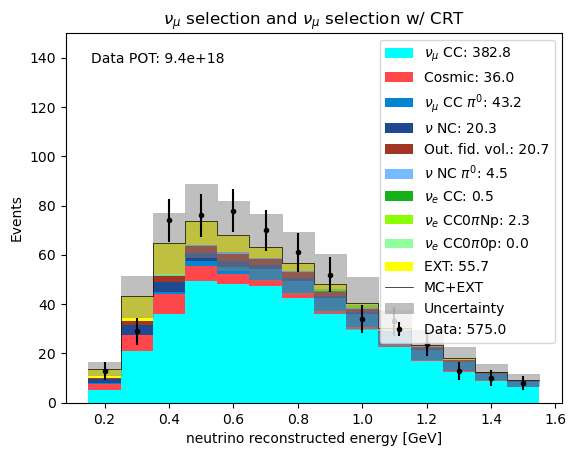

In [23]:
import matplotlib.pyplot as plt

ax = plotter_numu.plot(category_column="category", include_multisim_errors=True, add_ext_error_floor=False)
ax.set_ylim((0, 150))
# plt.savefig("plots/numu_sideband_with_drt_run3_crt.pdf")

In [7]:
# RUN = [1, 2, 3]
RUN = [3]
all_truth_filters = [
    "nue",
    "drt",
    # remove the ones below to save some time
    # "nc_pi0",
    # "cc_pi0",
    # "cc_nopi",
    # "cc_cpi",
    # "nc_nopi",
    # "nc_cpi",
]
rundata, mc_weights, data_pot = dl.load_runs(
    RUN,
    data="bnb",
    truth_filtered_sets=all_truth_filters,
    loadpi0variables=True,
    loadshowervariables=True,
    loadrecoveryvars=True,
    loadsystematics=True,
    load_lee=True,
)

../../data_loading.py:1023: RuntimeWarning: overflow encountered in multiply
  mc_Q2 = -1 * (mc_q_E * mc_q_E - mc_q_px * mc_q_px - mc_q_py * mc_q_py - mc_q_pz * mc_q_pz)
../../data_loading.py:1023: RuntimeWarning: invalid value encountered in subtract
  mc_Q2 = -1 * (mc_q_E * mc_q_E - mc_q_px * mc_q_px - mc_q_py * mc_q_py - mc_q_pz * mc_q_pz)
../../data_loading.py:542: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2 * e1 * e2 * (1 - px1 * px2 - py1 * py2 - pz1 * pz2))
../../data_loading.py:542: RuntimeWarning: overflow encountered in float_scalars
  return np.sqrt(2 * e1 * e2 * (1 - px1 * px2 - py1 * py2 - pz1 * pz2))
/Users/trettin/miniconda/envs/python3LEE/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
../../data_loading.py:705: RuntimeWarning: invalid value encountered in true_divide
  df["proton_pz"] = np.where((mc_E_prot > 0), mc_pz_prot / mc_p_prot, 

Loading lee sample


In [40]:
selection = "NPBDT"
preselection = "NP"
# binning_def = ("reco_e", 17, (0.01, 2.39), r"Reconstructed Energy [ GeV ]")
binning_def = ("reco_e", 10, (0.15, 1.55), r"Reconstructed Energy [GeV]")  # reproduce technote
binning = hist.Binning.from_config(*binning_def)
signal_generator = hist.RunHistGenerator(
    rundata,
    binning,
    data_pot=data_pot,
    selection=selection,
    preselection=preselection,
    sideband_generator=numu_generator,
    uncertainty_defaults=None,
)
plotter = rp.RunHistPlotter(signal_generator, selection_title=None)
plotter.title = plotter.get_selection_title(selection=selection, preselection=preselection)

DEBUG:plotting.histogram:Creating histogram generator for with binning: Binning(variable='reco_e', bin_edges=array([0.15, 0.29, 0.43, 0.57, 0.71, 0.85, 0.99, 1.13, 1.27, 1.41, 1.55]), label='Reconstructed Energy [GeV]', is_log=False)
DEBUG:plotting.histogram:Creating histogram generator for with binning: Binning(variable='reco_e', bin_edges=array([0.15, 0.29, 0.43, 0.57, 0.71, 0.85, 0.99, 1.13, 1.27, 1.41, 1.55]), label='Reconstructed Energy [GeV]', is_log=False)


DEBUG:plotting.histogram:Generating histogram with query: nslice == 1 and selected == 1 and shr_energy_tot_cali > 0.07 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and n_tracks_contained > 0 and nslice == 1 and selected == 1 and shr_energy_tot_cali > 0.07 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and n_tracks_contained > 0 and CosmicIPAll3D > 10. and trkpid < 0.02 and hits_ratio > 0.50 and shrmoliereavg < 9 and subcluster > 4 and trkfit < 0.65 and tksh_distance < 6.0 and (shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_max > 0.5 and shr_tkfit_dedx_max < 5.5) and tksh_angle > -0.9 and shr_trk_len < 300. and pi0_score > 0.67 and nonpi0_score > 0.70 and n_showers_contained == 1
DEBUG:plotting.histogram:Total number of events after filtering: 1
DEBUG:plotting.histogram:Histogram found in cache.
DEBUG:plotting.histogram:Using cached total covariance matrix.
DEBUG:plotting.histogram:Generating histogram w

(0.0, 10.0)

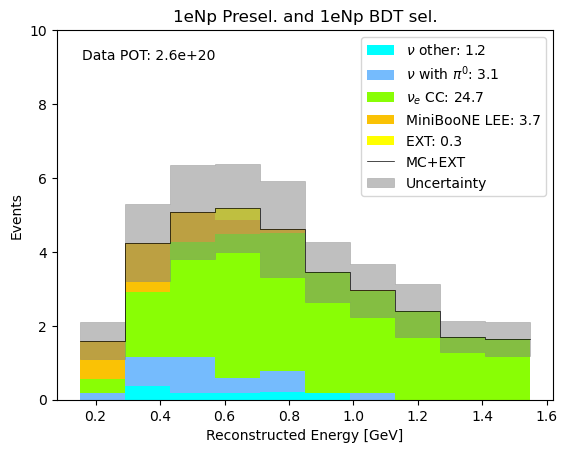

In [43]:
ax = plotter.plot(category_column="paper_category", include_multisim_errors=True, add_ext_error_floor=False, scale_to_pot=None, use_sideband=False)
ax.set_ylim((0, 10))

DEBUG:plotting.histogram:Generating histogram with query: nslice == 1 and selected == 1 and shr_energy_tot_cali > 0.07 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and n_tracks_contained > 0 and nslice == 1 and selected == 1 and shr_energy_tot_cali > 0.07 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and n_tracks_contained > 0 and CosmicIPAll3D > 10. and trkpid < 0.02 and hits_ratio > 0.50 and shrmoliereavg < 9 and subcluster > 4 and trkfit < 0.65 and tksh_distance < 6.0 and (shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_max > 0.5 and shr_tkfit_dedx_max < 5.5) and tksh_angle > -0.9 and shr_trk_len < 300. and pi0_score > 0.67 and nonpi0_score > 0.70 and n_showers_contained == 1
DEBUG:plotting.histogram:Total number of events after filtering: 1
DEBUG:plotting.histogram:Histogram found in cache.
DEBUG:plotting.histogram:Using cached total covariance matrix.
DEBUG:plotting.histogram:Generating histogram w

(0.0, 10.0)

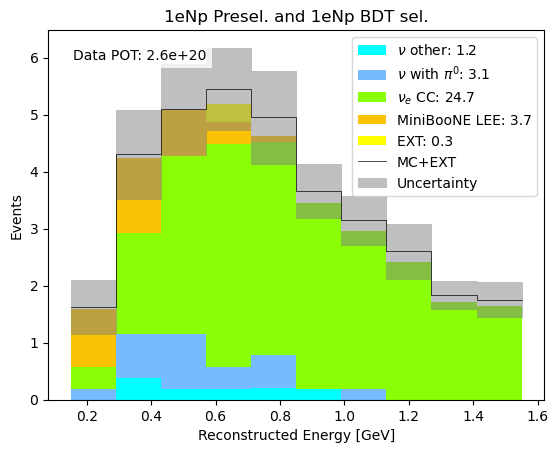

In [44]:
plotter.plot(category_column="paper_category", include_multisim_errors=True, add_ext_error_floor=False, scale_to_pot=None, use_sideband=True)
ax.set_ylim((0, 10))

In [45]:
sideband_generator = numu_generator.get_hist_generator(which="mc")
sideband_total_prediction = numu_generator.get_total_prediction(include_multisim_errors=True)
sideband_observed_hist = numu_generator.get_data_hist()

DEBUG:plotting.histogram:Generating histogram with query: nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 5 and reco_nu_vtx_sce_x < 251.  and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110.  and reco_nu_vtx_sce_z > 20 and reco_nu_vtx_sce_z < 986.  and (reco_nu_vtx_sce_z < 675 or reco_nu_vtx_sce_z > 775)  and topological_score > 0.06  and nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 5 and reco_nu_vtx_sce_x < 251.  and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110.  and reco_nu_vtx_sce_z > 20 and reco_nu_vtx_sce_z < 986.  and (reco_nu_vtx_sce_z < 675 or reco_nu_vtx_sce_z > 775)  and topological_score > 0.06  and n_muons_tot > 0 and (crtveto != 1 or crthitpe < 100) and _closestNuCosmicDist > 5.
DEBUG:plotting.histogram:Total number of events after filtering: 75141
DEBUG:plotting.histogram:Histogram found in cache.
DEBUG

DEBUG:plotting.histogram:Generating histogram with query: nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 5 and reco_nu_vtx_sce_x < 251.  and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110.  and reco_nu_vtx_sce_z > 20 and reco_nu_vtx_sce_z < 986.  and (reco_nu_vtx_sce_z < 675 or reco_nu_vtx_sce_z > 775)  and topological_score > 0.06  and nslice == 1 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and reco_nu_vtx_sce_x > 5 and reco_nu_vtx_sce_x < 251.  and reco_nu_vtx_sce_y > -110 and reco_nu_vtx_sce_y < 110.  and reco_nu_vtx_sce_z > 20 and reco_nu_vtx_sce_z < 986.  and (reco_nu_vtx_sce_z < 675 or reco_nu_vtx_sce_z > 775)  and topological_score > 0.06  and n_muons_tot > 0 and (crtveto != 1 or crthitpe < 100) and _closestNuCosmicDist > 5.
DEBUG:plotting.histogram:Total number of events after filtering: 75141
DEBUG:plotting.histogram:Histogram found in cache.
DEBUG

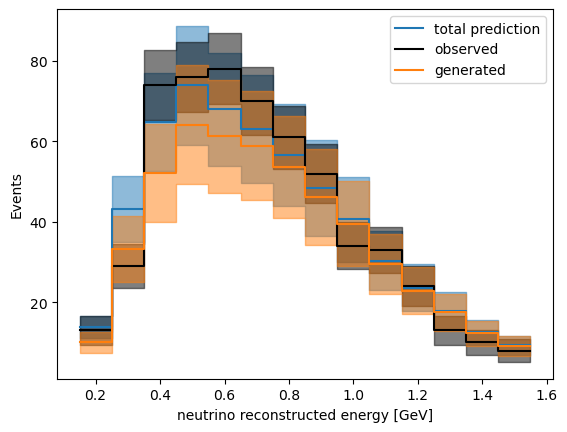

In [49]:
fig, ax = plt.subplots()
sideband_total_prediction.draw(ax=ax, label="total prediction")
sideband_observed_hist.draw(ax=ax, label="observed")
sideband_generator.generate(include_multisim_errors=True).draw(ax=ax, label="generated")
ax.legend()

DEBUG:plotting.histogram:Generating histogram with query: nslice == 1 and selected == 1 and shr_energy_tot_cali > 0.07 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and n_tracks_contained > 0 and nslice == 1 and selected == 1 and shr_energy_tot_cali > 0.07 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and n_tracks_contained > 0 and CosmicIPAll3D > 10. and trkpid < 0.02 and hits_ratio > 0.50 and shrmoliereavg < 9 and subcluster > 4 and trkfit < 0.65 and tksh_distance < 6.0 and (shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_max > 0.5 and shr_tkfit_dedx_max < 5.5) and tksh_angle > -0.9 and shr_trk_len < 300. and pi0_score > 0.67 and nonpi0_score > 0.70 and n_showers_contained == 1
DEBUG:plotting.histogram:Total number of events after filtering: 13717
DEBUG:plotting.histogram:Histogram found in cache.
DEBUG:plotting.histogram:Using cached total covariance matrix.


Histogram(binning=Binning(variable='reco_e', bin_edges=array([0.15, 0.29, 0.43, 0.57, 0.71, 0.85, 0.99, 1.13, 1.27, 1.41, 1.55]), label='Reconstructed Energy [GeV]', is_log=False), bin_counts=[1.5971816778182983+/-0.2673587203025818
 4.245875358581543+/-0.5074926018714905
 5.0794501304626465+/-0.4932088255882263
 4.87564754486084+/-0.3717990815639496
 4.619804382324219+/-0.43408092856407166
 3.4501399993896484+/-0.24881990253925323
 2.955415725708008+/-0.2439640462398529
 2.410999298095703+/-0.16005387902259827
 1.7062702178955078+/-0.11260256916284561
 1.6419563293457031+/-0.12186066061258316], label=, tex=)

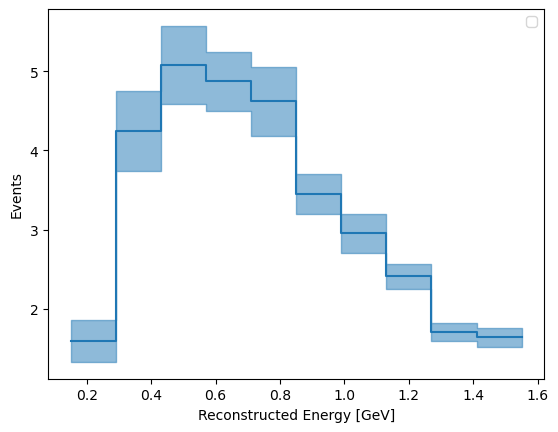

In [50]:
np_hist_gen = signal_generator.get_hist_generator(which="mc")
np_hist_gen.generate()

In [51]:
from importlib import reload
import logging
reload(logging)

logging.basicConfig(level=logging.WARN)

In [52]:
hist = np_hist_gen.generate(
    include_multisim_errors=True,
    use_sideband=True,
    sideband_generator=sideband_generator,
    sideband_total_prediction=sideband_total_prediction,
    sideband_observed_hist=sideband_observed_hist,
)

DEBUG:plotting.histogram:Generating histogram with query: nslice == 1 and selected == 1 and shr_energy_tot_cali > 0.07 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and n_tracks_contained > 0 and nslice == 1 and selected == 1 and shr_energy_tot_cali > 0.07 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and n_tracks_contained > 0 and CosmicIPAll3D > 10. and trkpid < 0.02 and hits_ratio > 0.50 and shrmoliereavg < 9 and subcluster > 4 and trkfit < 0.65 and tksh_distance < 6.0 and (shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_max > 0.5 and shr_tkfit_dedx_max < 5.5) and tksh_angle > -0.9 and shr_trk_len < 300. and pi0_score > 0.67 and nonpi0_score > 0.70 and n_showers_contained == 1
DEBUG:plotting.histogram:Total number of events after filtering: 13717
DEBUG:plotting.histogram:Histogram found in cache.
DEBUG:plotting.histogram:Using cached total covariance matrix.


In [36]:
selection = "ZPBDT"
preselection = "ZP"
# binning_def = ("reco_e", 17, (0.01, 2.39), r"Reconstructed Energy [ GeV ]")
# binning = hist.Binning.from_config(*binning_def)
signal_generator_zp = hist.RunHistGenerator(
    rundata,
    binning,
    data_pot=data_pot,
    selection=selection,
    preselection=preselection,
    sideband_generator=numu_generator,
    uncertainty_defaults=None,
)
plotter_zp = rp.RunHistPlotter(signal_generator_zp, selection_title=None)
plotter_zp.title = plotter.get_selection_title(selection=selection, preselection=preselection)

DEBUG:plotting.histogram:Creating histogram generator for with binning: Binning(variable='reco_e', bin_edges=array([0.15, 0.29, 0.43, 0.57, 0.71, 0.85, 0.99, 1.13, 1.27, 1.41, 1.55]), label='Reconstructed Energy [GeV]', is_log=False)
DEBUG:plotting.histogram:Creating histogram generator for with binning: Binning(variable='reco_e', bin_edges=array([0.15, 0.29, 0.43, 0.57, 0.71, 0.85, 0.99, 1.13, 1.27, 1.41, 1.55]), label='Reconstructed Energy [GeV]', is_log=False)


DEBUG:plotting.histogram:Generating histogram with query: nslice == 1 and selected == 1 and shr_energy_tot_cali > 0.07 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and n_tracks_contained == 0 and nslice == 1 and selected == 1 and shr_energy_tot_cali > 0.07 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and n_showers_contained == 1 and CosmicIPAll3D > 10. and CosmicDirAll3D > -0.9 and CosmicDirAll3D < 0.9 and shrmoliereavg < 15 and subcluster > 4 and trkfit < 0.65 and secondshower_Y_nhit < 50 and shr_trk_sce_start_y > -100 and shr_trk_sce_start_y < 80 and shr_trk_sce_end_y > -100 and shr_trk_sce_end_y < 100  and shr_trk_len < 300. and (n_tracks_tot == 0 or (n_tracks_tot>0 and tk1sh1_angle_alltk>-0.9)) and bkg_score >0.72 and n_tracks_contained == 0 and (n_tracks_tot == 0 or (n_tracks_tot>0 and tk1sh1_angle_alltk>-0.9))
DEBUG:plotting.histogram:Total number of events after filtering: 9
DEBUG:plotting.

<AxesSubplot:title={'center':'1e0p Presel. and 1e0p BDT sel.'}, xlabel='Reconstructed Energy [GeV]', ylabel='Events'>

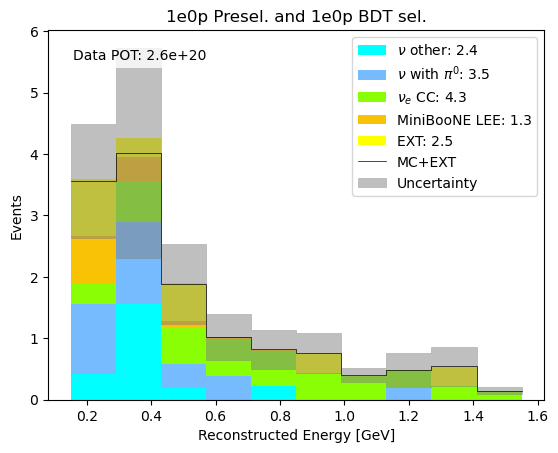

In [39]:
plotter_zp.plot(category_column="paper_category", include_multisim_errors=True, add_ext_error_floor=False, scale_to_pot=None, use_sideband=True)

In [144]:
# we can also extract the histogram generators and from those get the multiband covariance matrices
sideband_hist_gen = numu_generator.get_hist_generator(which="mc")
np_hist_gen = signal_generator.get_hist_generator(which="mc")
zp_hist_gen = signal_generator_zp.get_hist_generator(which="mc")

In [145]:
ms_column = "weightsFlux"
hist_gens = [np_hist_gen, zp_hist_gen, sideband_hist_gen]
multiband_covariance = hist.HistogramGenerator.multiband_covariance(
    hist_gens,
    ms_column=ms_column
)

In [146]:
# convert the covariance into a correlation matrix
with np.errstate(divide='ignore', invalid='ignore'):
    multiband_correlation = multiband_covariance / np.sqrt(np.outer(np.diag(multiband_covariance), np.diag(multiband_covariance)))
# replace NANs with 0s
multiband_correlation = np.nan_to_num(multiband_correlation)

In [147]:
multiband_correlation

array([[1.        , 0.91180833, 0.91463358, ..., 0.43796469, 0.50701065,
        0.55897647],
       [0.91180833, 1.        , 0.96615825, ..., 0.26466958, 0.33586961,
        0.37464891],
       [0.91463358, 0.96615825, 1.        , ..., 0.39615309, 0.47242897,
        0.51407094],
       ...,
       [0.43796469, 0.26466958, 0.39615309, ..., 1.        , 0.99150472,
        0.96899472],
       [0.50701065, 0.33586961, 0.47242897, ..., 0.99150472, 1.        ,
        0.98533945],
       [0.55897647, 0.37464891, 0.51407094, ..., 0.96899472, 0.98533945,
        1.        ]])

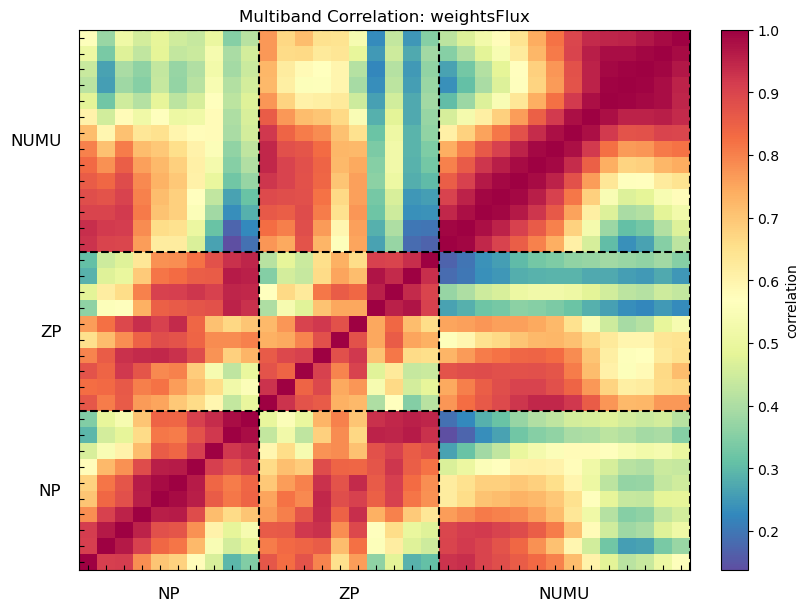

In [151]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
# show the covariance matrix as a heatmap
X, Y = np.meshgrid(np.arange(multiband_correlation.shape[0] + 1), np.arange(multiband_correlation.shape[1] + 1))
p = ax.pcolormesh(X, Y, multiband_correlation.T, cmap="Spectral_r", shading="flat")
# colorbar
cbar = fig.colorbar(p, ax=ax)
cbar.set_label("correlation")
ax.set_title(f"Multiband Correlation: {ms_column}")
# turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
# set tick marks at every bin
ax.set_xticks(np.arange(multiband_correlation.shape[0]) + 0.5, minor=False)
ax.set_yticks(np.arange(multiband_correlation.shape[1]) + 0.5, minor=False)
ax.tick_params(axis='both', which='both', direction="in")


# draw vertical and horizontal lines splitting the different histograms that went
# into the covariance matrix
pos = 0
hist_gen_labels = ["NP", "ZP", "NUMU"]
for hist_gen, label in zip(hist_gens, hist_gen_labels):
    pos += hist_gen.binning.n_bins
    ax.axvline(pos, color="k", linestyle="--")
    ax.axhline(pos, color="k", linestyle="--")
    ax.text(pos - hist_gen.binning.n_bins / 2, -1, label, ha="center", va="top", fontsize=12)
    ax.text(-1, pos - hist_gen.binning.n_bins / 2, label, ha="right", va="center", fontsize=12)

plt.savefig(f"plots/multiband_correlation_{ms_column}.pdf")